### Imports

In [6]:
from tqdm import tqdm
from utils.utils import *

import networkx as nx
import numpy as np
import pandas as pd
import os
import sys

%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1.35 ms (started: 2023-06-08 18:13:09 -05:00)


### Parameters

In [7]:
import json
  
# Opening JSON file
file = open("parameters.json")
params = json.load(file)

dir = os.path.dirname(os.getcwd())
print(dir)

exp = params["exp"]
print("Exp:\t\t", exp)

groups_id = params["groups_id"]
print("Groups id:\t", groups_id)

subgroups_id = params["subgroups_id"]
print("Subgroups id:\t", subgroups_id)

option = params["option"]
print("Option:\t", option)

/home/ealvarez/Project/GNN_Filter
Exp:		 exp6
Groups id:	 ['WT', 'zwf1^', 'pck1^']
Subgroups id:	 {'WT': ['1', '2', '3', '4', '5'], 'zwf1^': ['1', '2', '3'], 'pck1^': ['1', '2']}
Option:	 dyn
time: 2.62 ms (started: 2023-06-08 18:13:09 -05:00)


### Load dataset

In [8]:
# load dataset groups
df_join_raw = pd.read_csv("input/{}_raw.csv".format(exp), index_col=0)
df_join_raw

,zwf1^3.4,zwf1^3.4.1,zwf1^3.4.2,zwf1^3.4.3,zwf1^3.4.4,zwf1^3.4.5,zwf1^3.4.6,zwf1^3.4.7,zwf1^3.4.8,zwf1^3.4.9,...,WT3.4,WT3.4.1,WT3.4.2,WT3.4.3,WT3.4.4,WT3.4.5,WT3.4.6,WT3.4.7,WT3.4.8,WT3.4.9
59.0049,1,47,508,360,675,232,59,345,346,504,...,45,817,32,307,410,716,228,187,361,952
59.0137,53182,57902,51861,62812,54291,54395,59054,52547,57544,63538,...,45747,39677,47205,38697,54320,62610,47283,49927,43632,48511
59.0291,2151,2102,2334,2864,2393,2246,2331,1954,2310,2528,...,1852,1717,1830,1660,2006,2539,2103,2276,1643,2522
59.0370,83,174,366,1134,693,464,235,479,443,691,...,225,349,185,429,186,278,364,368,115,887
59.0453,1,1,51,642,493,143,11,227,160,154,...,60,293,1,336,65,142,1,182,10,684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996.5509,2470,2435,2465,2727,2773,2157,2168,2623,2256,2636,...,1866,1834,1669,674,2533,1017,2983,1814,2160,1899
996.7096,3366,3241,2909,3469,3538,3010,3031,2872,2709,3601,...,1748,1419,1160,621,1758,1474,1973,1023,1769,1629
997.5542,2818,2335,1807,1679,2222,2070,2158,1835,2087,2784,...,1168,828,1162,1103,2253,1419,2306,1542,827,1433
997.7131,1901,1469,1572,1916,2180,2555,2101,1656,2543,2643,...,659,1370,714,390,1660,1513,1843,1448,691,1376


time: 201 ms (started: 2023-06-08 18:13:09 -05:00)


### Generate graphs

In [9]:
# logarithm
df_join_raw_log = log10_global(df_join_raw)
df_join_raw_log.head()

,zwf1^3.4,zwf1^3.4.1,zwf1^3.4.2,zwf1^3.4.3,zwf1^3.4.4,zwf1^3.4.5,zwf1^3.4.6,zwf1^3.4.7,zwf1^3.4.8,zwf1^3.4.9,...,WT3.4,WT3.4.1,WT3.4.2,WT3.4.3,WT3.4.4,WT3.4.5,WT3.4.6,WT3.4.7,WT3.4.8,WT3.4.9
59.0049,0.000000,1.672098,2.705864,2.556303,2.829304,2.365488,1.770852,2.537819,2.539076,2.702431,...,1.653213,2.912222,1.505150,2.487138,2.612784,2.854913,2.357935,2.271842,2.557507,2.978637
59.0137,4.725765,4.762694,4.714841,4.798043,4.734728,4.735559,4.771249,4.720548,4.760000,4.803034,...,4.660363,4.598539,4.673988,4.587677,4.734960,4.796644,4.674705,4.698335,4.639805,4.685840
59.0291,3.332640,3.322633,3.368101,3.456973,3.378943,3.351410,3.367542,3.290925,3.363612,3.402777,...,3.267641,3.234770,3.262451,3.220108,3.302331,3.404663,3.322839,3.357172,3.215638,3.401745
59.0370,1.919078,2.240549,2.563481,3.054613,2.840733,2.666518,2.371068,2.680336,2.646404,2.839478,...,2.352183,2.542825,2.267172,2.632457,2.269513,2.444045,2.561101,2.565848,2.060698,2.947924
59.0453,0.000000,0.000000,1.707570,2.807535,2.692847,2.155336,1.041393,2.356026,2.204120,2.187521,...,1.778151,2.466868,0.000000,2.526339,1.812913,2.152288,0.000000,2.260071,1.000000,2.835056


time: 617 ms (started: 2023-06-08 18:13:09 -05:00)


In [10]:
# split graph in groups and subgroups

list_df_groups_subgroups = split_groups_subgroups(df_join_raw_log, groups_id, subgroups_id)
list_df_groups_subgroups[2][1].head()

,pck1^2.4,pck1^2.4.1,pck1^2.4.2,pck1^2.4.3,pck1^2.4.4,pck1^2.4.5,pck1^2.4.6,pck1^2.4.7,pck1^2.4.8,pck1^2.4.9,...,pck1^2.3,pck1^2.3.1,pck1^2.3.2,pck1^2.3.3,pck1^2.3.4,pck1^2.3.5,pck1^2.3.6,pck1^2.3.7,pck1^2.3.8,pck1^2.3.9
59.0049,2.954725,1.908485,2.576341,2.688420,2.945961,2.629410,2.624282,2.838219,2.583199,2.346353,...,2.932981,2.816241,2.634477,2.525045,2.301030,2.826075,2.408240,2.459392,2.498311,2.630428
59.0137,4.531070,4.353435,4.559727,4.481084,4.542302,4.455728,4.560803,4.500840,4.407951,4.385481,...,4.777304,4.818622,4.815996,4.811005,4.722288,4.749118,4.783761,4.809573,4.793434,4.825095
59.0291,3.289366,2.975432,3.303196,3.249443,3.256718,3.190051,3.304275,3.174351,3.145818,3.012415,...,3.402777,3.493876,3.456821,3.461799,3.384174,3.394977,3.459091,3.482159,3.390228,3.471878
59.0370,2.808886,2.143015,2.876218,2.783189,2.841359,2.835691,2.833147,2.606381,2.791691,2.068186,...,2.717671,2.959518,2.997823,2.816241,2.869232,2.865104,2.814248,2.840733,2.843233,2.859739
59.0453,2.143015,1.892095,2.546543,2.617000,2.571709,2.588832,2.575188,2.547775,2.537819,2.127105,...,2.257679,2.661813,2.632457,2.190332,2.506505,2.409933,2.534026,2.130334,2.498311,2.618048


time: 40.8 ms (started: 2023-06-08 18:13:10 -05:00)


In [11]:
# transpose
list_groups_subgroups_t = transpose_global(list_df_groups_subgroups)
list_groups_subgroups_t[2][1].head()

,59.0049,59.0137,59.0291,59.0370,59.0453,60.0171,60.9871,61.9884,71.0139,74.0249,...,992.8229,993.5530,994.9357,995.4648,995.9381,996.5509,996.7096,997.5542,997.7131,998.4845
0,2.954725,4.531070,3.289366,2.808886,2.143015,3.078094,2.471292,3.322426,3.174932,3.578868,...,2.045323,3.190892,3.282622,2.965672,1.812913,3.067815,3.049993,3.054996,3.083144,3.226084
1,1.908485,4.353435,2.975432,2.143015,1.892095,3.068928,2.812913,3.312812,3.159266,3.355068,...,2.539076,2.862728,3.475235,2.481443,3.049218,2.965202,3.247237,3.266937,3.301030,3.223496
2,2.576341,4.559727,3.303196,2.876218,2.546543,2.977724,2.705008,3.173478,3.257679,3.608526,...,2.619093,2.946943,3.387390,2.908485,2.936514,2.911158,3.281942,3.118265,3.191451,3.219846
3,2.688420,4.481084,3.249443,2.783189,2.617000,2.832509,2.648360,3.150449,2.831230,3.532245,...,2.453318,2.969416,3.302114,3.152900,3.041393,3.086004,3.242541,2.913284,3.091667,3.197832
4,2.945961,4.542302,3.256718,2.841359,2.571709,3.141763,2.613842,3.326541,3.099335,3.614475,...,1.755875,3.198107,3.463445,2.795185,3.013680,2.804821,3.197281,3.274850,3.214844,3.320146


time: 21 ms (started: 2023-06-08 18:13:10 -05:00)


In [12]:
# correlation matrix

list_groups_subgroups_t_corr = correlation_global(list_groups_subgroups_t, "pearson")
list_groups_subgroups_t_corr[2][1].head()

100%|██████████| 3/3 [00:29<00:00,  9.84s/it]


,59.0049,59.0137,59.0291,59.0370,59.0453,60.0171,60.9871,61.9884,71.0139,74.0249,...,992.8229,993.5530,994.9357,995.4648,995.9381,996.5509,996.7096,997.5542,997.7131,998.4845
59.0049,1.000000,0.287129,0.270324,0.363969,0.217656,0.161898,0.077930,0.090846,0.258561,0.162302,...,0.344321,0.371656,0.195416,0.375245,0.041282,0.234870,0.111588,0.178812,0.006935,0.339209
59.0137,0.287129,1.000000,0.988618,0.828448,0.044054,0.897362,0.498810,0.588602,0.661068,0.617955,...,0.257626,0.747545,0.927433,0.707794,0.736854,0.833366,0.256676,0.644093,0.119219,-0.010579
59.0291,0.270324,0.988618,1.000000,0.876040,0.070717,0.881252,0.485546,0.604307,0.658134,0.603539,...,0.213466,0.758967,0.900093,0.737102,0.714229,0.834500,0.284788,0.647233,0.151205,-0.003832
59.0370,0.363969,0.828448,0.876040,1.000000,0.331904,0.656170,0.337278,0.547675,0.578815,0.503546,...,0.091596,0.610543,0.697462,0.729919,0.547925,0.704851,0.221317,0.528873,0.048181,-0.028942
59.0453,0.217656,0.044054,0.070717,0.331904,1.000000,-0.018638,-0.040043,-0.015895,-0.043291,-0.052287,...,0.042301,0.132157,0.008229,0.096801,0.047423,0.128597,0.033424,0.006409,-0.020402,-0.127789


time: 29.5 s (started: 2023-06-08 18:13:10 -05:00)


In [13]:
# build graph

list_groups_subgroups_t_corr_g = build_graph_weight_global(exp, list_groups_subgroups_t_corr, groups_id, subgroups_id, threshold=0.5)
list_groups_subgroups_t_corr_g[2][0].head()

100%|██████████| 3/3 [34:06<00:00, 682.18s/it]


,source,target,weight
0,59.0049,99.9716,0.817106
1,59.0049,120.9310,0.547441
2,59.0049,172.0403,0.545892
3,59.0049,183.0464,-0.500707
4,59.0049,192.0498,0.524971


time: 34min 6s (started: 2023-06-08 18:13:40 -05:00)


In [14]:
# create dataset - nodes/edge data for DGL framework

create_graph_data(exp, groups_id, subgroups_id)

100%|██████████| 3/3 [03:55<00:00, 78.57s/it] 

time: 3min 55s (started: 2023-06-08 18:47:47 -05:00)


### Dynamic graph to Static graph

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      int64  
 1   target  6 non-null      int64  
 2   weight  6 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 272.0 bytes
None
   source  target  weight
0       1       2     0.5
1       2       3     0.6
2       1       4     0.7
3       2       4     0.8
4       3       4     0.9
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6 non-null      string 
 1   target  6 non-null      string 
 2   weight  6 non-null      float64
dtypes: float64(1), string(2)
memory usage: 272.0 bytes
None
['1', '2', '3', '4', '5']
[('1', '2'), ('1', '4'), ('2', '3'), ('2', '4'), ('3', '4'), ('4', '5')]


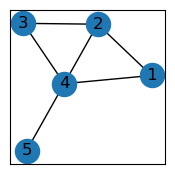

0.5

time: 115 ms (started: 2023-06-08 18:51:42 -05:00)


In [15]:
# elist = [(2, 1), (3, 2), (4, 1), (2, 4)]

elist = [(1, 2, 0.5), (2, 3, 0.6), (1, 4, 0.7), (2, 4, 0.8), (3, 4, 0.9), (4, 5, 1.0)]
df = pd.DataFrame(elist, columns=["source", "target", "weight"])
print(df.info())
print(df.head())
df[["source", "target"]] = df[["source", "target"]].astype("string")
print(df.info())
df.to_csv("del.csv", index=False)
# G1 = nx.Graph()
# G1.add_weighted_edges_from(elist)
G1 = nx.from_pandas_edgelist(df, edge_attr=["weight"])

print(G1.nodes())
print(G1.edges())

plt.figure(1,figsize=(2, 2)) 
nx.draw_networkx(G1)
plt.show()

G1.get_edge_data("2", "1", default=0)["weight"]

[1, 2, 3, 4]
[(1, 2), (1, 4), (2, 3), (2, 4)]


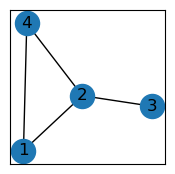

time: 101 ms (started: 2023-06-08 18:51:43 -05:00)


In [16]:
elist = [(1, 2, 0.5), (2, 3, 0.5), (1, 4, 0.5), (2, 4, 0.5)]
G2 = nx.Graph()
G2.add_weighted_edges_from(elist)

print(G2.nodes())
print(G2.edges())

plt.figure(1,figsize=(2, 2)) 
nx.draw_networkx(G2)
plt.show()

[1, 2, 3, 4]
[(1, 2), (1, 4), (2, 3), (2, 4)]


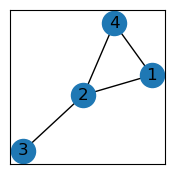

time: 96.4 ms (started: 2023-06-08 18:51:43 -05:00)


In [17]:
elist = [(1, 2, 0.5), (2, 3, 0.5), (1, 4, 0.5), (2, 4, 0.5)]
G3 = nx.Graph()
G3.add_weighted_edges_from(elist)

print(G3.nodes())
print(G3.edges())

plt.figure(1,figsize=(2, 2)) 
nx.draw_networkx(G3)
plt.show()

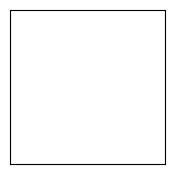

time: 89.3 ms (started: 2023-06-08 18:51:43 -05:00)


In [18]:
R = nx.intersection(G1, G2)

plt.figure(3,figsize=(2, 2)) 
nx.draw_networkx(R)
plt.show()


[('B1', 'C1', 0), ('B2', 'C2', 0), ('B3', 'C3', 0), ('B4', 'C4', 0)]
['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'C1', 'C2', 'C3', 'C4']
[('A1', 'A2'), ('A1', 'A4'), ('A2', 'A3'), ('A2', 'A4'), ('A3', 'A4'), ('A4', 'A5'), ('B1', 'B2'), ('B1', 'B4'), ('B1', 'C1'), ('B2', 'B3'), ('B2', 'B4'), ('B2', 'C2'), ('B3', 'C3'), ('B4', 'C4'), ('C1', 'C2'), ('C1', 'C4'), ('C2', 'C3'), ('C2', 'C4')]


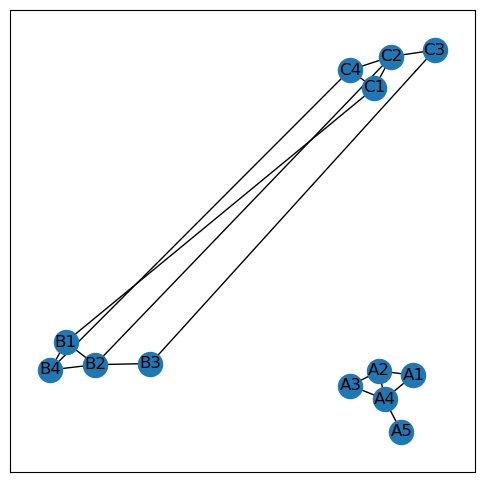

time: 150 ms (started: 2023-06-08 18:51:43 -05:00)


In [19]:
# connected pairs of nodes
list_graphs = [G1, G2, G3]
rename = [chr(k + 65) for k in range(len(list_graphs))]
list_edges = []

for k in range(len(list_graphs) - 1):
    nodes = list(list_graphs[k].nodes())
    for node in nodes:
        if list_graphs[k + 1].has_node(node):
            list_edges.append((rename[k] + str(node), rename[k + 1] + str(node), 0))
            # break

# U = nx.union(G1, G2, rename=("A", "B"))
# U = nx.full_join(G1, G2, rename=("A", "B"))
U = nx.union_all(list_graphs, rename=rename)

# append edges
U.add_weighted_edges_from(list_edges)

print()
print(list_edges)
print(U.nodes())
print(U.edges())

plt.figure(3,figsize=(6, 6)) 
nx.draw_networkx(U)
plt.show()

In [20]:
# create data

def create_graph_data_other(groups_id, subgroups_id, option):
    for group in tqdm(groups_id):
        list_graphs = []
        for subgroup in tqdm(subgroups_id[group]):
            df_weighted_edges = pd.read_csv("output/{}/preprocessing/edges/edges_{}_{}.csv".format(exp, group, subgroup), dtype={"source": "string", "target": "string"})
            G = nx.from_pandas_edgelist(df_weighted_edges, "source", "target", edge_attr="weight")
            list_graphs.append(G)

        rename = [chr(k + 65) for k in range(len(list_graphs))]
        list_edges = []

        for k in range(len(list_graphs) - 1):
            nodes = list(list_graphs[k].nodes())
            for node in nodes:
                if list_graphs[k + 1].has_node(node):
                    list_edges.append((rename[k] + str(node), rename[k + 1] + str(node), 0))
                    if option == "str":
                        break

        U = nx.union_all(list_graphs, rename=rename)
        # append edges
        U.add_weighted_edges_from(list_edges)

        mapping = dict(zip(list(U.nodes()), range(U.number_of_nodes())))
        U = nx.relabel_nodes(U, mapping)
        degree = dict(U.degree())

        df_nodes = pd.DataFrame(degree.items(), columns=["idx", "degree"])
        df_nodes["id"] = list(mapping.keys())
        df_nodes.to_csv("output/{}/preprocessing/graphs_data/nodes_data_{}_{}.csv".format(exp, group, option), index=False)

        edges = list(U.edges())
        df_edges = pd.DataFrame(edges, columns=["source", "target"])
        df_edges["weight"] = [U.get_edge_data(edge[0], edge[1])["weight"] for edge in edges]
        df_edges.to_csv("output/{}/preprocessing/graphs_data/edges_data_{}_{}.csv".format(exp, group, option), index=False)


time: 1.96 ms (started: 2023-06-08 18:51:43 -05:00)


In [ ]:
create_graph_data_other(groups_id, subgroups_id, option="dyn")

In [ ]:
df_nodes = pd.read_csv("output/{}/preprocessing/graphs_data/nodes_data_{}_dyn.csv".format(exp, groups_id[0]))
df_nodes.head()

,idx,degree,id
0,0,11,A59.0049
1,1,26,A274.0123
2,2,65,A277.0867
3,3,61,A369.1213
4,4,70,A369.1541


time: 16 ms (started: 2023-06-08 08:07:29 -05:00)


In [ ]:
df_edges = pd.read_csv("output/{}/preprocessing/graphs_data/edges_data_{}_dyn.csv".format(exp, groups_id[0]))
print(df_edges.shape)
df_edges.head()

(12257101, 3)


,source,target,weight
0,0,1,0.629097
1,0,2,0.526495
2,0,3,0.530122
3,0,4,0.524363
4,0,5,0.504517


time: 2.15 s (started: 2023-06-08 08:07:29 -05:00)


In [ ]:
create_graph_data_other(groups_id, subgroups_id, option="str")

100%|██████████| 3/3 [07:14<00:00, 144.91s/it]

time: 7min 14s (started: 2023-06-08 08:33:36 -05:00)


In [ ]:
df_nodes = pd.read_csv("output/{}/preprocessing/graphs_data/nodes_data_{}_str.csv".format(exp, groups_id[0]))
df_nodes.head()

In [ ]:
df_edges = pd.read_csv("output/{}/preprocessing/graphs_data/edges_data_{}_str.csv".format(exp, groups_id[0]))
print(df_edges.shape)
df_edges.head()